In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import tensorflow as tf

mat = scipy.io.loadmat('data_sl_gomex.mat')

In [2]:
del mat["__header__"], mat["__version__"], mat["__globals__"]
mat.keys()

dict_keys(['di', 'si', 'tim'])

In [3]:
print(mat["di"].shape,mat["si"].shape,mat["tim"].shape)
print(mat["di"][0])
print(mat["tim"][0])
print(mat["si"])

(1, 11) (11, 1188) (1, 1188)
[   0  178  494  591  994 1394 1551 1919 2104 2322 2502]
[701266 701296 701326 ... 736816 736846 736876]
[[        nan         nan         nan ...  0.04892696  0.04574972
   0.04270454]
 [        nan         nan         nan ...  0.04353015  0.04075246
   0.03770596]
 [ 0.0453938   0.03999344  0.03475421 ...  0.07399587  0.07101622
   0.06751459]
 ...
 [-0.00946163 -0.01287696 -0.01503584 ...  0.01823817  0.01861357
   0.01871538]
 [-0.0093943  -0.01279946 -0.01510585 ...  0.02120678  0.0255633
   0.02942173]
 [-0.00933468 -0.01273547 -0.01516366 ...  0.03739476  0.03809526
   0.03827388]]


In [4]:
data_raw = pd.DataFrame(mat["si"].T, index=mat["tim"][0], columns=mat["di"][0].astype(str))
data_raw.fillna(0, inplace=True)
data_raw = data_raw.rename_axis('Datetime').reset_index()
data_raw.head()

,Datetime,0,178,494,591,994,1394,1551,1919,2104,2322,2502
0,701266,0.0,0.0,0.045394,0.041656,0.026127,0.010714,0.004665,-0.009515,-0.009462,-0.009394,-0.009335
1,701296,0.0,0.0,0.039993,0.036388,0.021411,0.006553,0.000728,-0.012926,-0.012877,-0.012799,-0.012735
2,701326,0.0,0.0,0.034754,0.031369,0.017307,0.003349,-0.002129,-0.014977,-0.015036,-0.015106,-0.015164
3,701356,0.0,0.0,0.030413,0.027286,0.014295,0.001401,-0.003660,-0.015584,-0.015796,-0.016054,-0.016267
4,701386,0.0,0.0,0.027589,0.024702,0.012705,0.000799,-0.003875,-0.014936,-0.015254,-0.015638,-0.015954


In [5]:
testing_window = 200
x_window = 10 # 太短了 120
time_shift = 1
n_output = 1
lstm_unit = 8
learning_rate = 0.01

data = data_raw.iloc[:, 1:]

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
train_idx = int((len(data)-testing_window-x_window)*0.8)+x_window
print(train_idx)
sc = MinMaxScaler().fit(data.iloc[:train_idx, :])
data.iloc[:, :] = sc.transform(data.iloc[:, :])

792


In [6]:
station_list = mat['di'][0]
len(station_list)

11

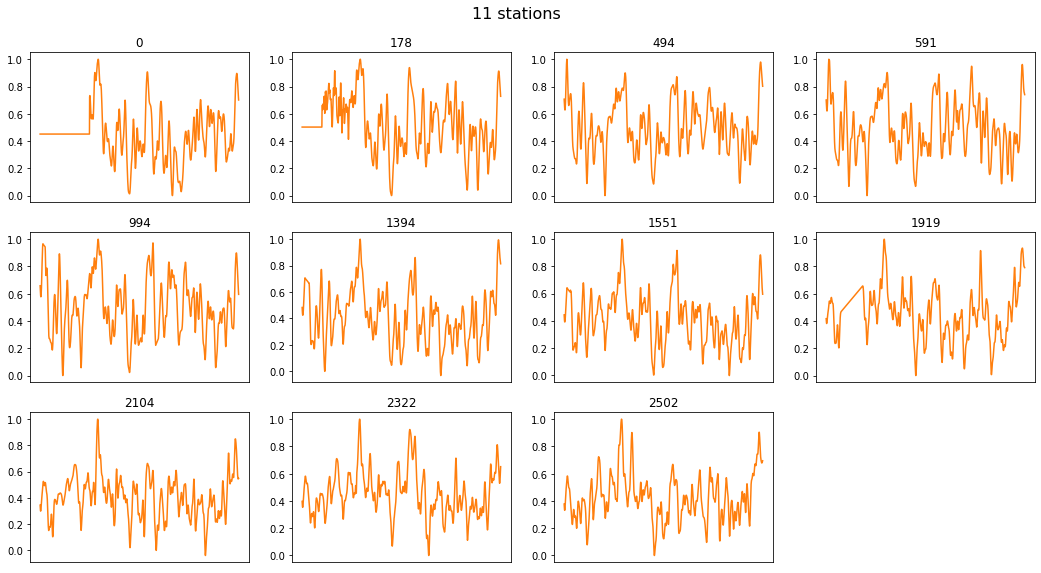

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,16))
fig.suptitle('11 stations', fontsize=16, y = 0.92)
for i in range(len(station_list)):
    station = data.columns[i]
    plt.subplot(5, 4, i+1)
    plt.plot(mat["tim"].T, data[station], color = 'C1')
    plt.title(station)
    plt.xticks([])
    # plt.ylim(-0.1,0.1)
plt.show()

In [8]:
datetime_list = mat['tim'].T
# data = data_raw.iloc[:, 1:]
import numpy as np

error_count = 0

X = np.zeros((len(data)-x_window-time_shift+1, len(data.columns), x_window))
Y = np.zeros((len(data)-x_window-time_shift+1, len(data.columns), n_output))
for i in range(X.shape[0]):
    X[i] = np.array(data.iloc[i:i+x_window]).T
    # label_width = np.array(data.loc[i+x_window+time_shift-1])[:,np.newaxis]
    label_width = np.array(data.loc[i+x_window+time_shift-1:i+x_window+time_shift+n_output-2].T)
    # print(label_width.shape)
    # break
    try:
        Y[i] = label_width
    except:
        error_count += 1
        continue
print(X.shape, Y.shape, error_count)
X = X[:X.shape[0]-error_count]
Y = Y[:Y.shape[0]-error_count]

(1178, 11, 10) (1178, 11, 1) 0


In [9]:
X_train = X[:-testing_window]
Y_train = Y[:-testing_window]
X_test = X[-testing_window:]
Y_test = Y[-testing_window:]
val_idx = int(X_train.shape[0]*0.8)
X_val = X_train[val_idx:]
Y_val = Y_train[val_idx:]
X_train = X_train[:val_idx]
Y_train = Y_train[:val_idx]
print(X_train.shape, Y_val.shape, X_test.shape)

(782, 11, 10) (196, 11, 1) (200, 11, 10)


In [10]:
X_train = X_train.reshape(X_train.shape[0]*11,x_window,1)
Y_train = Y_train.reshape(Y_train.shape[0]*11,n_output)
X_val = X_val.reshape(X_val.shape[0]*11,x_window,1)
Y_val = Y_val.reshape(Y_val.shape[0]*11,n_output)
X_true = X_test.reshape(testing_window*11,x_window,1)
Y_true = Y_test.reshape(testing_window*11,n_output)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.LSTM(lstm_unit, activation="relu", return_sequences=False),
    layers.Dense(n_output),
    ])
opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.01, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train, Y_train,
                    epochs=2000, validation_data=(X_val, Y_val),
                    shuffle=True, batch_size=32,
                    verbose=1, callbacks=[callback])

Epoch 1/2000


2021-12-01 11:46:57.108060: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-01 11:46:57.108217: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


269/269 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0151
Epoch 2/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0094
Epoch 3/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 4/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 5/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 8/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/2000
269/269 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/2000
269/269 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss:

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
model.summary()

In [ ]:
station_list = list(data.columns)[:]
time_list = []
for j in datetime_list[-len(Y_test):]:
    time_list.append(j[0])

Y_pred = np.zeros((200,11))

for i in range(11):
    Y_pred_batch = model.predict(X_test[:,i,:].reshape([testing_window, x_window, 1]))[:,0]
    Y_pred[:,i] = Y_pred_batch
    
mse = tf.keras.losses.MeanSquaredError()

print("MSE: ", mse(Y_test[:,:,0], Y_pred).numpy())

Y_pred_test = Y_pred # 没inverse transform

Y_pred_unomalized = sc.inverse_transform(Y_pred)
pred_df = pd.DataFrame(Y_pred_unomalized, columns=station_list, index=time_list)
pred_df = pred_df.rename_axis('Datetime').reset_index()

Y_test_unomalized = sc.inverse_transform(Y_test.reshape(200,11))
print("MSE: ", mse(Y_test_unomalized[:,:], Y_pred_unomalized).numpy())

In [ ]:
import matplotlib.pyplot as plt
temp_df = data_raw.iloc[:]
fig = plt.figure(figsize=(24,18))
fig.suptitle('11 stations', fontsize=16, y = 0.92)
for i in range(len(station_list)):
    station = data_raw.columns[i+1]
    plt.subplot(4, 3, i+1)
    plt.plot(temp_df['Datetime'], temp_df[station], color = 'k', alpha = 0.3)
    plt.plot(pred_df['Datetime'], pred_df[station], alpha = 0.5)
    plt.axvline(x=min(pred_df['Datetime']), color='k', linestyle=(0, (5, 5)))
    plt.title(station)
    plt.xticks([])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import random

Y_pred_sample = model.predict(X_true)

x = []
for i in range(1500):
    x.append(i)
    
fig = plt.figure(figsize=(24,18))
for i in range(9):
    r = random.randrange(0,X_true.shape[0],1)
    plt.subplot(4, 3, i+1)
    plt.scatter(x[x_window:x_window+5], Y_true[r:r+5], color="C1")
    plt.scatter(x[x_window:x_window+5], Y_pred_sample[r:r+5], color="C2")
    plt.plot(x[x_window:x_window+5], Y_true[r:r+5], color="C1")
    plt.plot(x[0:x_window], X_true[r])
plt.show()

In [ ]:
Y_pred_test = pd.DataFrame(Y_pred_test)

X_new = np.zeros((len(Y_pred_test)-x_window-time_shift+1, len(data.columns), x_window))
Y_new = np.zeros((len(Y_pred_test)-x_window-time_shift+1, len(data.columns), n_output))
for i in range(X_new.shape[0]):
    X_new[i] = np.array(Y_pred_test.iloc[i:i+x_window]).T

print(Y_new.shape)
Y_new = Y[-(len(Y_pred_test)-x_window-time_shift+1):,]

In [ ]:
Y_pred_new = np.zeros((X_new.shape[0],11))

for i in range(11):
    Y_pred_batch_new = model.predict(X_new[:,i,:].reshape([X_new.shape[0], x_window, 1]))[:,0]
    Y_pred_new[:,i] = Y_pred_batch_new
    
mse = tf.keras.losses.MeanSquaredError()

print("MSE: ", mse(Y_test[-X_new.shape[0]:,:,0], Y_pred_new).numpy())

Y_pred_unomalized = sc.inverse_transform(Y_pred_new)

Y_test_unomalized = sc.inverse_transform(Y_new.reshape(X_new.shape[0],11))
print("MSE: ", mse(Y_test_unomalized[:,:], Y_pred_unomalized).numpy())

In [ ]:
import matplotlib.pyplot as plt
# temp_df = data_raw.iloc[-testing_window:]
fig = plt.figure(figsize=(24,16))
fig.suptitle('11 stations', fontsize=16, y = 0.92)
for i in range(len(station_list)):
    station = data_raw.columns[i+1]
    plt.subplot(4, 3, i+1)
    # plt.plot(temp_df['Datetime'], temp_df[station], color = 'k', alpha = 0.3)
    # plt.plot(pred_df['Datetime'], pred_df[station], alpha = 0.5)
    plt.plot(Y_test_unomalized[:,i])
    plt.plot(Y_pred_unomalized[:,i])
    # plt.axvline(x=min(pred_df['Datetime']), color='k', linestyle=(0, (5, 5)))
    plt.title(station)
    plt.xticks([])
plt.show()